### Imports
---

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, VideoMAEForVideoClassification, TrainingArguments, Trainer, VideoMAEConfig
import evaluate
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm

import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

import cv2



c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)


### Data Directories
---

In [3]:
train_root = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Train"
test_root = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Test"
val_root = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Validation"

output_dir = r"C:\Users\Brandon\Documents\DM_Project\output"
os.makedirs(output_dir, exist_ok=True)


### Verify Data
---

The uneven distribution of different class videos is something that needs to be addressed before training the model. It may be more computationally efficient to directly remove videos from the over-represented classes, but for now we will just downsample said classes right before training.

In [4]:
def count_videos(root_dir):
    total = 0
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        # Count subdirectories (each subdirectory is a video folder)
        num_videos = sum(
            1 for file in os.listdir(cls_path)
            if file.lower().endswith('.mp4')
        )
        print(f"{cls}: {num_videos} videos")
        total += num_videos
    return total

train_count = count_videos(train_root)
test_count = count_videos(test_root)
val_count = count_videos(val_root)

print(f"\nTotal Train videos: {train_count}")
print(f"Total Test videos: {test_count}")
print(f"Total Validation videos: {val_count}")

Abuse: 40 videos
Arrest: 40 videos
Arson: 40 videos
Assault: 40 videos
Burglary: 80 videos
Explosion: 40 videos
Fighting: 40 videos
NormalVideos: 170 videos
RoadAccidents: 120 videos
Robbery: 120 videos
Shooting: 40 videos
Shoplifting: 40 videos
Stealing: 80 videos
Vandalism: 40 videos
Abuse: 5 videos
Arrest: 5 videos
Arson: 5 videos
Assault: 5 videos
Burglary: 10 videos
Explosion: 5 videos
Fighting: 5 videos
NormalVideos: 150 videos
RoadAccidents: 15 videos
Robbery: 15 videos
Shooting: 5 videos
Shoplifting: 5 videos
Stealing: 10 videos
Vandalism: 5 videos
Abuse: 5 videos
Arrest: 5 videos
Arson: 5 videos
Assault: 5 videos
Burglary: 10 videos
Explosion: 5 videos
Fighting: 5 videos
NormalVideos: 19 videos
RoadAccidents: 15 videos
Robbery: 15 videos
Shooting: 5 videos
Shoplifting: 5 videos
Stealing: 10 videos
Vandalism: 5 videos

Total Train videos: 930
Total Test videos: 245
Total Validation videos: 114


### Data Processing
---

In [5]:
class_labels = sorted(os.listdir(train_root))
num_classes = len(class_labels)
label2id = {label: idx for idx, label in enumerate(class_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(label2id)

{'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'NormalVideos': 7, 'RoadAccidents': 8, 'Robbery': 9, 'Shooting': 10, 'Shoplifting': 11, 'Stealing': 12, 'Vandalism': 13}


In [6]:
def MapAndPath(root, label2id):
    videopaths = []

    for clss in sorted(os.listdir(root)):
        class_dir = os.path.join(root, clss)
        if not os.path.isdir(class_dir):
            continue

        for file in os.listdir(class_dir):
            if file.lower().endswith('.mp4'):
                filepath = os.path.join(class_dir, file)
                label_id = label2id[clss]
                videopaths.append((filepath, {"label": label_id, "video_path": filepath}))
                
    return videopaths
    

### Dataset Class
---

removed /255 in video_array

In [7]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

class SafeLabeledVideoDataset(Dataset):
    def __init__(self, labeled_video_paths, transform=None, num_frames=16, frame_size=224):
        self.labeled_video_paths = labeled_video_paths
        self.transform = transform
        self.num_frames = num_frames
        self.frame_size = frame_size
        self.length = len(labeled_video_paths)

    def __len__(self):
        return self.length

    def _load_video_cv2(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Could not open video")

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (self.frame_size, self.frame_size))
            # Store as (H, W, C) first
            frames.append(frame)

        cap.release()

        if len(frames) == 0:
            raise ValueError("No frames extracted")

        # Convert to numpy array and normalize
        video_array = np.array(frames).astype(np.float32)  # (T, H, W, C)
        # Convert to tensor and permute to (C, T, H, W) for transforms
        video_tensor = torch.from_numpy(video_array).permute(3, 0, 1, 2)  # (C, T, H, W)
        
        return video_tensor

    def __getitem__(self, idx):
        video_path, metadata = self.labeled_video_paths[idx]
        try:
            video_tensor = self._load_video_cv2(video_path)
            

            if self.transform:
                video_dict = {"video": video_tensor}
                
                video_dict = self.transform(video_dict)
                
                video_tensor = video_dict["video"]

            return {
                "video": video_tensor,
                "label": metadata["label"],
                "video_path": video_path,
            }

        except Exception as e:
            print(f"[LOAD FAILED] {video_path} | Error: {e}")
            import traceback
            traceback.print_exc()
            # Create dummy tensor in correct format
            dummy = torch.zeros(3, self.num_frames, self.frame_size, self.frame_size)
            return {"video": dummy, "label": metadata["label"], "video_path": video_path}

### Load VideoMAE
---

In [8]:
import transformers.utils as utils
utils.is_torch_available = lambda: True

In [9]:
print(torch.cuda.is_available())

True


changing model config to support dropout

In [10]:
model_name = "MCG-NJU/videomae-base"
config = VideoMAEConfig.from_pretrained(model_name)
config.hidden_dropout_prob = 0.1
config.attention_probs_dropout_prob = 0.1
config.num_labels = num_classes
config.label2id = label2id
config.id2label = id2label

c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
model_name = "MCG-NJU/videomae-base"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = VideoMAEForVideoClassification.from_pretrained(model_name, config = config, ignore_mismatched_sizes=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

device

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

### Data Transforms & Dataset
---

In [12]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                    Normalize(mean, std),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)




In [13]:
train_paths = MapAndPath(train_root, label2id)
val_paths = MapAndPath(val_root, label2id)
test_paths = MapAndPath(test_root, label2id)

print(f"Train: {len(train_paths)}, Test: {len(test_paths)}, Val: {len(val_paths)}")

train_dataset = SafeLabeledVideoDataset(
    labeled_video_paths=train_paths,
    transform=train_transform
    
)

test_dataset = SafeLabeledVideoDataset(
    labeled_video_paths=test_paths,
    transform=val_transform
    
)

val_dataset = SafeLabeledVideoDataset(
    labeled_video_paths=val_paths,
    transform=val_transform
    
)


Train: 930, Test: 245, Val: 114


### Trainer
---

In [14]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=preds, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([ex["video"] for ex in examples]) 
    # Ensure the tensor is in the right format for VideoMAE
    # VideoMAE expects: (batch_size, num_frames, num_channels, height, width)
    pixel_values = pixel_values.permute(0, 2, 1, 3, 4)  # from (B, C, T, H, W) to (B, T, C, H, W)
    
    labels = torch.tensor([ex["label"] for ex in examples])
    paths = [ex.get("video_path", "unknown") for ex in examples]
    return {"pixel_values": pixel_values, "labels": labels, "video_path": paths}

num_epochs = 10
batch_size = 4

training_args = TrainingArguments(
        output_dir=str(output_dir),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_steps=10,
        learning_rate=3e-5,
        warmup_ratio=0.1,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        num_train_epochs=num_epochs,
        fp16=torch.cuda.is_available(),
        push_to_hub=False,
        remove_unused_columns=False,
        max_steps=(len(train_dataset) // batch_size) * num_epochs,
    )

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=image_processor,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
    )


max_steps is given, it will override any value given in num_train_epochs


DOWNSAMPLING

In [15]:
print(label2id)

{'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'NormalVideos': 7, 'RoadAccidents': 8, 'Robbery': 9, 'Shooting': 10, 'Shoplifting': 11, 'Stealing': 12, 'Vandalism': 13}


In [16]:
import random

def downsample_classes(video_paths, label2id, downsample_config):
    """
    Downsample specific classes to target counts
    
    Args:
        video_paths: List of (path, metadata) tuples
        label2id: Dictionary mapping class names to labels
        downsample_config: Dictionary mapping class names to target counts
                          e.g., {'NormalVideos': 50, 'Burglary': 40}
    """
    # Organize videos by class
    videos_by_class = {class_name: [] for class_name in label2id.keys()}
    
    for path, metadata in video_paths:
        label = metadata['label']
        # Find class name from label
        class_name = [k for k, v in label2id.items() if v == label][0]
        videos_by_class[class_name].append((path, metadata))
    
    # Print original counts
    print("Original class distribution:")
    for class_name, videos in videos_by_class.items():
        print(f"  {class_name}: {len(videos)}")
    
    # Downsample specified classes
    random.seed(42)  # For reproducibility
    downsampled_videos = []
    
    print("\nDownsampling:")
    for class_name, videos in videos_by_class.items():
        if class_name in downsample_config:
            target_count = downsample_config[class_name]
            if len(videos) > target_count:
                videos = random.sample(videos, target_count)
                print(f"  {class_name}: {len(videos_by_class[class_name])} → {len(videos)}")
            else:
                print(f"  {class_name}: {len(videos)} (no downsampling needed)")
        
        downsampled_videos.extend(videos)
    
    # Shuffle to mix classes
    random.shuffle(downsampled_videos)
    
    print(f"\nTotal videos: {len(video_paths)} → {len(downsampled_videos)}")
    
    return downsampled_videos

# Apply downsampling
print("\n" + "="*60)
print("DOWNSAMPLING TRAINING SET")
print("="*60)
train_downsample_config = {
    'NormalVideos': 40,
    'Burglary': 40,
    'RoadAccidents': 40,
    'Robbery': 40,
    'Stealing': 40
}
train_paths = downsample_classes(train_paths, label2id, train_downsample_config)

print("\n" + "="*60)
print("DOWNSAMPLING TEST SET")
print("="*60)
test_downsample_config = {
    'NormalVideos': 15,
    'RoadAccidents': 15,
    'Robbery': 15
}
test_paths = downsample_classes(test_paths, label2id, test_downsample_config)

print("\n" + "="*60)
print("DOWNSAMPLING VALIDATION SET")
print("="*60)
val_downsample_config = {
    'NormalVideos': 15,
    'RoadAccidents': 15,
    'Robbery': 15
}
val_paths = downsample_classes(val_paths, label2id, val_downsample_config)

# Recreate datasets with balanced data
print("\n=== Recreating Datasets ===")
train_dataset = SafeLabeledVideoDataset(
    labeled_video_paths=train_paths,
    transform=train_transform
)

test_dataset = SafeLabeledVideoDataset(
    labeled_video_paths=test_paths,
    transform=val_transform
)

val_dataset = SafeLabeledVideoDataset(
    labeled_video_paths=val_paths,
    transform=val_transform
)

print(f"\nFinal dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Val: {len(val_dataset)}")


DOWNSAMPLING TRAINING SET
Original class distribution:
  Abuse: 40
  Arrest: 40
  Arson: 40
  Assault: 40
  Burglary: 80
  Explosion: 40
  Fighting: 40
  NormalVideos: 170
  RoadAccidents: 120
  Robbery: 120
  Shooting: 40
  Shoplifting: 40
  Stealing: 80
  Vandalism: 40

Downsampling:
  Burglary: 80 → 40
  NormalVideos: 170 → 40
  RoadAccidents: 120 → 40
  Robbery: 120 → 40
  Stealing: 80 → 40

Total videos: 930 → 560

DOWNSAMPLING TEST SET
Original class distribution:
  Abuse: 5
  Arrest: 5
  Arson: 5
  Assault: 5
  Burglary: 10
  Explosion: 5
  Fighting: 5
  NormalVideos: 150
  RoadAccidents: 15
  Robbery: 15
  Shooting: 5
  Shoplifting: 5
  Stealing: 10
  Vandalism: 5

Downsampling:
  NormalVideos: 150 → 15
  RoadAccidents: 15 (no downsampling needed)
  Robbery: 15 (no downsampling needed)

Total videos: 245 → 110

DOWNSAMPLING VALIDATION SET
Original class distribution:
  Abuse: 5
  Arrest: 5
  Arson: 5
  Assault: 5
  Burglary: 10
  Explosion: 5
  Fighting: 5
  NormalVideos: 19
 

**TRAINING CONFIGURATION**

learning rate: 
batch_size:
accumulation steps:

In [17]:
EPOCHS = 10
BATCH_SIZE = 2  # increased from 1
GRADIENT_ACCUMULATION_STEPS = 4  # Simulate larger batch size
LEARNING_RATE = 3e-5  # higher learning rate to overcome initial model weights
SAVE_EVERY_N_EPOCHS = 1  # Save checkpoints frequently

# Mixed precision training for memory efficiency
use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler() if use_amp else None

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Learning rate scheduler
total_steps = (len(train_dataset) // BATCH_SIZE) * EPOCHS // GRADIENT_ACCUMULATION_STEPS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=total_steps
)

TRAINING LOOP

In [18]:
def train_epoch(model, train_loader, optimizer, scheduler, scaler, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    optimizer.zero_grad()
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        try:
            # Move to device
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "video_path"]}
            labels = batch["labels"].to(device)
            
            # Mixed precision training
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(**inputs, labels=labels)
                    loss = outputs.loss / GRADIENT_ACCUMULATION_STEPS
                
                scaler.scale(loss).backward()
            else:
                outputs = model(**inputs, labels=labels)
                loss = outputs.loss / GRADIENT_ACCUMULATION_STEPS
                loss.backward()
            
            # Gradient accumulation
            if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                if use_amp:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                
                scheduler.step()
                optimizer.zero_grad()
            
            # Statistics
            total_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
            
            # Clear cache periodically
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
                
        except Exception as e:
            tqdm.write(f"Error in batch {batch_idx}: {e}")
            continue
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            try:
                inputs = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "video_path"]}
                labels = batch["labels"].to(device)
                
                if use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = model(**inputs, labels=labels)
                else:
                    outputs = model(**inputs, labels=labels)
                
                loss = outputs.loss
                total_loss += loss.item()
                
                preds = outputs.logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
            except Exception as e:
                tqdm.write(f"Validation error: {e}")
                continue
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

DATA LOADERS

In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows, 2-4 for Linux
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

TRAINING

In [20]:
best_val_acc = 0.0
training_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"Starting training for {EPOCHS} epochs...")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"Using mixed precision: {use_amp}\n")
train_start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, scaler, device, epoch
    )
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, device)
    
    # Save history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save checkpoint
    if (epoch + 1) % SAVE_EVERY_N_EPOCHS == 0:
        checkpoint_path = os.path.join(output_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = os.path.join(output_dir, "best_model.pt")
        torch.save(model.state_dict(), best_model_path)
        print(f"★ New best model saved! Val Acc: {val_acc:.2f}%")
    
    # Clear cache
    torch.cuda.empty_cache()

train_total = time.time() - train_start_time
print(f"\n{'='*50}")
print("Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Total training time: {train_total:.1f} seconds ({train_total/60:.2f} minutes)")
print(f"{'='*50}")

Starting training for 10 epochs...
Training samples: 560
Validation samples: 110
Effective batch size: 8
Using mixed precision: True


Epoch 1/10


Epoch 1:   0%|          | 0/280 [00:00<?, ?it/s]C:\Users\Brandon\AppData\Local\Temp\ipykernel_19092\1258551260.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/55 [00:00<?, ?it/s]C:\Users\Brandon\AppData\Local\Temp\ipykernel_19092\1258551260.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 55/55 [00:30<00:00,  1.83it/s]



Epoch 1 Summary:
Train Loss: 2.6544 | Train Acc: 7.14%
Val Loss: 2.6071 | Val Acc: 11.82%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_1.pt
★ New best model saved! Val Acc: 11.82%

Epoch 2/10


Validating: 100%|██████████| 55/55 [00:30<00:00,  1.82it/s]



Epoch 2 Summary:
Train Loss: 2.5705 | Train Acc: 13.39%
Val Loss: 2.5321 | Val Acc: 14.55%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_2.pt
★ New best model saved! Val Acc: 14.55%

Epoch 3/10


Validating: 100%|██████████| 55/55 [00:30<00:00,  1.82it/s]



Epoch 3 Summary:
Train Loss: 2.4594 | Train Acc: 14.64%
Val Loss: 2.4534 | Val Acc: 19.09%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_3.pt
★ New best model saved! Val Acc: 19.09%

Epoch 4/10


Validating: 100%|██████████| 55/55 [00:29<00:00,  1.85it/s]



Epoch 4 Summary:
Train Loss: 2.3623 | Train Acc: 21.43%
Val Loss: 2.2636 | Val Acc: 26.36%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_4.pt
★ New best model saved! Val Acc: 26.36%

Epoch 5/10


Validating: 100%|██████████| 55/55 [00:29<00:00,  1.86it/s]



Epoch 5 Summary:
Train Loss: 2.2262 | Train Acc: 26.61%
Val Loss: 2.3011 | Val Acc: 25.45%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_5.pt

Epoch 6/10


Validating: 100%|██████████| 55/55 [00:29<00:00,  1.88it/s]



Epoch 6 Summary:
Train Loss: 2.0881 | Train Acc: 31.61%
Val Loss: 2.2193 | Val Acc: 22.73%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_6.pt

Epoch 7/10


Validating: 100%|██████████| 55/55 [00:30<00:00,  1.81it/s]



Epoch 7 Summary:
Train Loss: 1.9960 | Train Acc: 33.93%
Val Loss: 2.1802 | Val Acc: 25.45%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_7.pt

Epoch 8/10


Validating: 100%|██████████| 55/55 [00:29<00:00,  1.86it/s]



Epoch 8 Summary:
Train Loss: 1.8939 | Train Acc: 38.21%
Val Loss: 2.1467 | Val Acc: 27.27%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_8.pt
★ New best model saved! Val Acc: 27.27%

Epoch 9/10


Validating: 100%|██████████| 55/55 [00:30<00:00,  1.81it/s]



Epoch 9 Summary:
Train Loss: 1.8520 | Train Acc: 39.82%
Val Loss: 2.1664 | Val Acc: 26.36%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_9.pt

Epoch 10/10


Validating: 100%|██████████| 55/55 [00:29<00:00,  1.89it/s]



Epoch 10 Summary:
Train Loss: 1.8083 | Train Acc: 42.86%
Val Loss: 2.1614 | Val Acc: 26.36%
Checkpoint saved to C:\Users\Brandon\Documents\DM_Project\output\checkpoint_epoch_10.pt

Training Complete!
Best Validation Accuracy: 27.27%
Total training time: 2304.7 seconds (38.41 minutes)


PLOT HISTORY

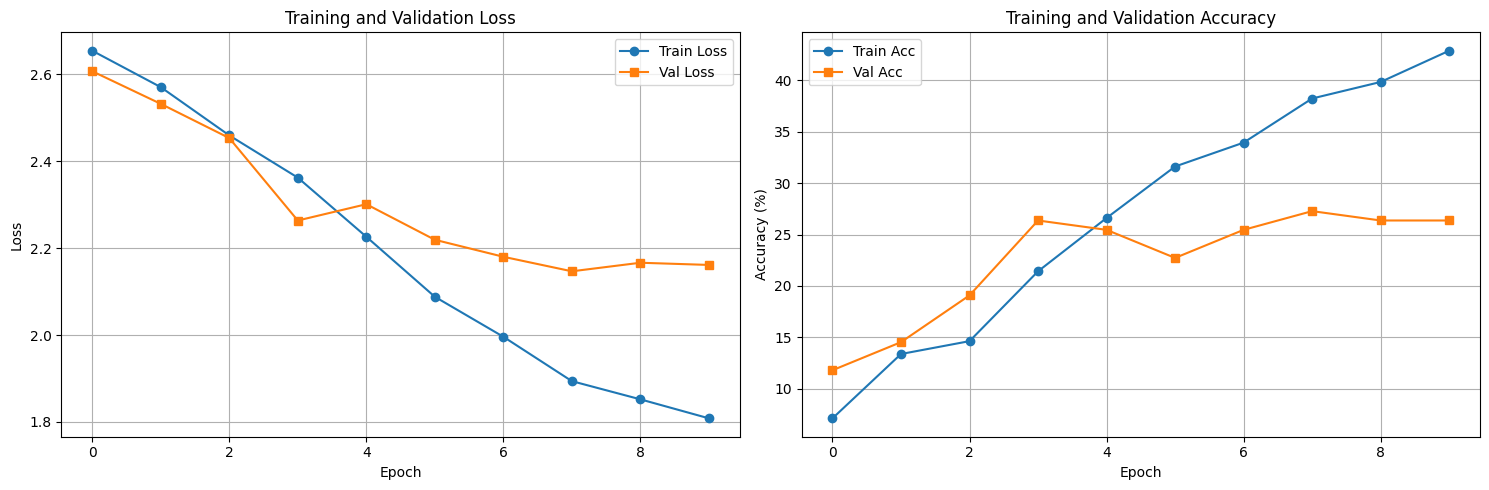


Training history plot saved to C:\Users\Brandon\Documents\DM_Project\output\training_history.png


In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(training_history['train_loss'], label='Train Loss', marker='o')
ax1.plot(training_history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(training_history['train_acc'], label='Train Acc', marker='o')
ax2.plot(training_history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
history_plot_path = os.path.join(output_dir, 'training_history.png')
plt.savefig(history_plot_path)
plt.show()
print(f"\nTraining history plot saved to {history_plot_path}")

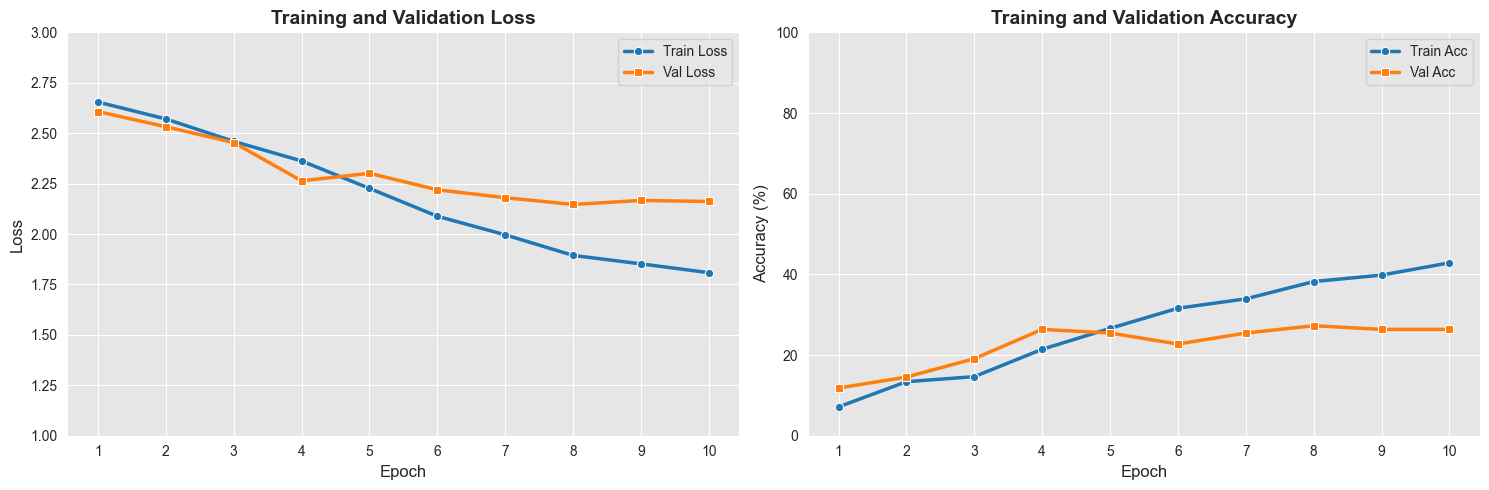


Training history plot saved to C:\Users\Brandon\Documents\DM_Project\output\training_history.png


In [22]:
sns.set_style("darkgrid", {"axes.facecolor": ".9", "grid.color": "white"})

epochs = range(1, len(training_history['train_loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
sns.lineplot(x=epochs, y=training_history['train_loss'], marker='o', ax=axes[0], label='Train Loss', linewidth=2.5)
sns.lineplot(x=epochs, y=training_history['val_loss'], marker='s', ax=axes[0], label='Val Loss', linewidth=2.5)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].set_xticks(list(epochs))
axes[0].set_ylim(1.0, 3.0)
axes[0].grid(True, alpha=1.0)

# Accuracy plot
sns.lineplot(x=epochs, y=training_history['train_acc'], marker='o', ax=axes[1], label='Train Acc', linewidth=2.5)
sns.lineplot(x=epochs, y=training_history['val_acc'], marker='s', ax=axes[1], label='Val Acc', linewidth=2.5)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend()
axes[1].set_xticks(list(epochs))
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=1.0)

plt.tight_layout()
history_plot_path = os.path.join(output_dir, 'training_history.png')
plt.savefig(history_plot_path, dpi=300)
plt.show()

print(f"\nTraining history plot saved to {history_plot_path}")

In [23]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load(os.path.join(output_dir, "best_model.pt")))
model.eval()
print("Best model loaded successfully!")


Loading best model for testing...
Best model loaded successfully!


In [24]:
# Check what the model expects
print(f"Model num_frames: {model.config.num_frames}")
print(f"Model image size: {model.config.image_size}")
print(f"Model num channels: {model.config.num_channels}")

# Make sure your transforms match the model config
num_frames_to_sample = model.config.num_frames

Model num_frames: 16
Model image size: 224
Model num channels: 3


### Testing Loop
---

In [25]:
model.eval()
all_preds, all_labels, failed_paths = [], [], []

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn,
)

test_start_time = time.time()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        try:
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "video_path"]}
            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            preds = outputs.logits.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())
        except Exception as e:
            # Use tqdm.write to avoid breaking the tqdm bar
            tqdm.write(f"Batch failed: {batch.get('video_path', [])} | {e}")
            failed_paths.extend(batch.get("video_path", []))
            # Add dummy preds matching the number of labels in the batch (if available)
            batch_size_fallback = len(batch.get('video_path', [])) or 1
            all_preds.extend([0] * batch_size_fallback)
            if 'labels' in batch:
                try:
                    all_labels.extend(batch['labels'].cpu().tolist())
                except Exception:
                    all_labels.extend([0] * batch_size_fallback)
            else:
                all_labels.extend([0] * batch_size_fallback)

test_total = time.time() - test_start_time
print(f"Failed videos: {len(failed_paths)}")
if failed_paths:
    print("First 5 failed paths:", failed_paths[:5])
print(f"Total test (evaluation) time: {test_total:.1f} seconds ({test_total/60:.2f} minutes)")


Evaluating: 100%|██████████| 28/28 [00:30<00:00,  1.10s/it]

Failed videos: 0
Total test (evaluation) time: 30.7 seconds (0.51 minutes)


Getting probabilities: 100%|██████████| 28/28 [00:30<00:00,  1.09s/it]
C:\Users\Brandon\AppData\Local\Temp\ipykernel_19092\2917985664.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_19092\2917985664.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_19092\2917985664.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_19092\2917985664.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_19092\2917985664.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Tem

Predictions shape: (110, 14)
Labels shape: (110,)

ROC AUC (macro): 0.7622
ROC AUC (micro): 0.7909


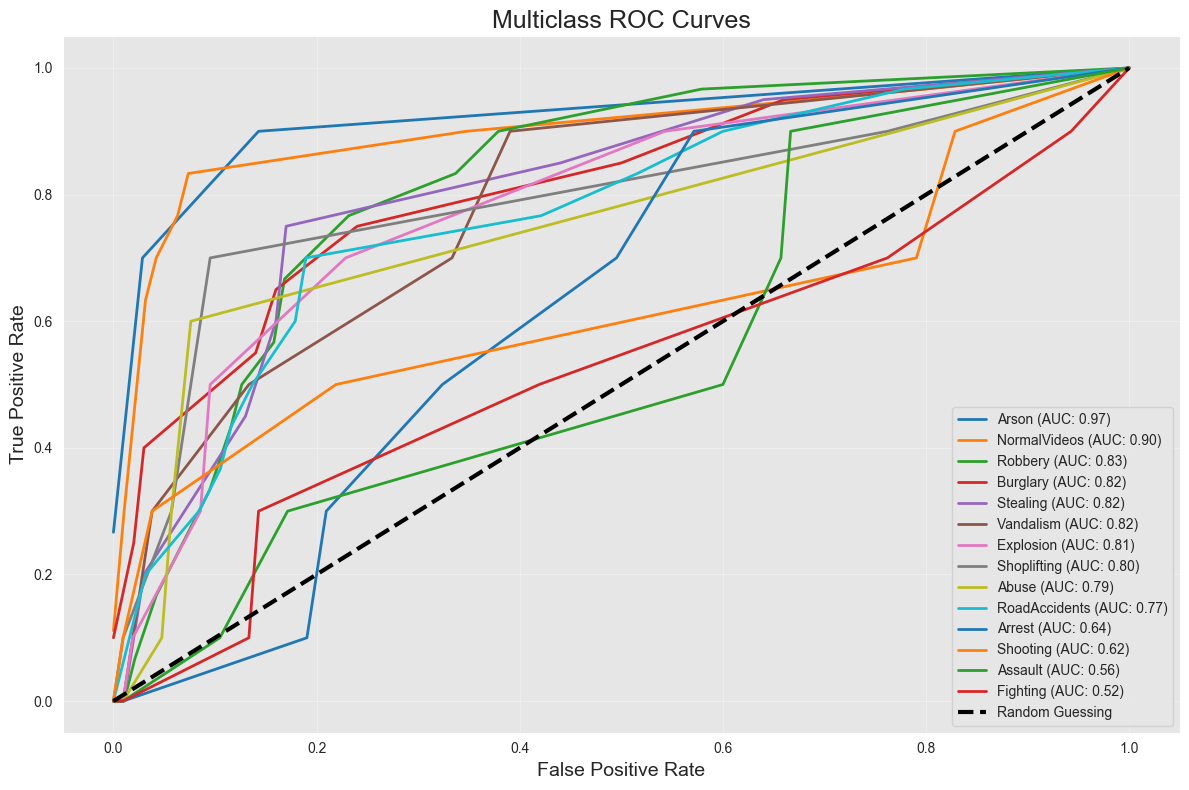

In [26]:
model.eval()
all_preds_proba = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Getting probabilities"):
        try:
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "video_path"]}
            labels = batch["labels"]
            
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
            
            all_preds_proba.extend(probs)
            all_labels.extend(labels.cpu().tolist())
        except Exception as e:
            tqdm.write(f"Probability batch failed: {e}")
            continue

# --- Convert to numpy arrays ---
y_pred = np.array(all_preds_proba)
y_test = np.array(all_labels)

print(f"Predictions shape: {y_pred.shape}")
print(f"Labels shape: {y_test.shape}")

# --- Prepare ROC data ---
lb = LabelBinarizer()
lb.fit(y_test)
y_test_bin = lb.transform(y_test)

# --- Seaborn style ---
sns.set_style("darkgrid", {"axes.facecolor": ".9", "grid.color": "white"})

fig, ax = plt.subplots(figsize=(12, 8))

# --- Compute ROC for each class first ---
roc_data = []
for idx, c_label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, idx].astype(int), y_pred[:, idx])
    roc_auc = auc(fpr, tpr)
    roc_data.append((c_label, fpr, tpr, roc_auc))

# --- Sort by descending AUC ---
roc_data.sort(key=lambda x: x[3], reverse=True)

# --- Plot ROC curves (sorted) ---
palette = sns.color_palette("tab10", len(class_labels))
for i, (c_label, fpr, tpr, roc_auc) in enumerate(roc_data):
    sns.lineplot(
        x=fpr,
        y=tpr,
        ax=ax,
        lw=2,
        label=f"{c_label} (AUC: {roc_auc:.2f})",
        color=palette[i],
        ci=None  # no shaded area
    )

# --- Random guessing line ---
sns.lineplot(x=[0, 1], y=[0, 1], color="black", lw=3, linestyle="--", label="Random Guessing")

# --- Compute macro & micro AUC ---
roc_score_macro = roc_auc_score(y_test_bin, y_pred, average="macro")
roc_score_micro = roc_auc_score(y_test_bin, y_pred, average="micro")

print(f"\nROC AUC (macro): {roc_score_macro:.4f}")
print(f"ROC AUC (micro): {roc_score_micro:.4f}")

# --- Finalize plot ---
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.set_title("Multiclass ROC Curves", fontsize=18)
ax.legend(fontsize=10, loc="lower right")
ax.grid(alpha=0.3)

plt.tight_layout()
roc_plot_path = os.path.join(output_dir, "roc_multiclass.png")
plt.savefig(roc_plot_path, dpi=300)
plt.show()


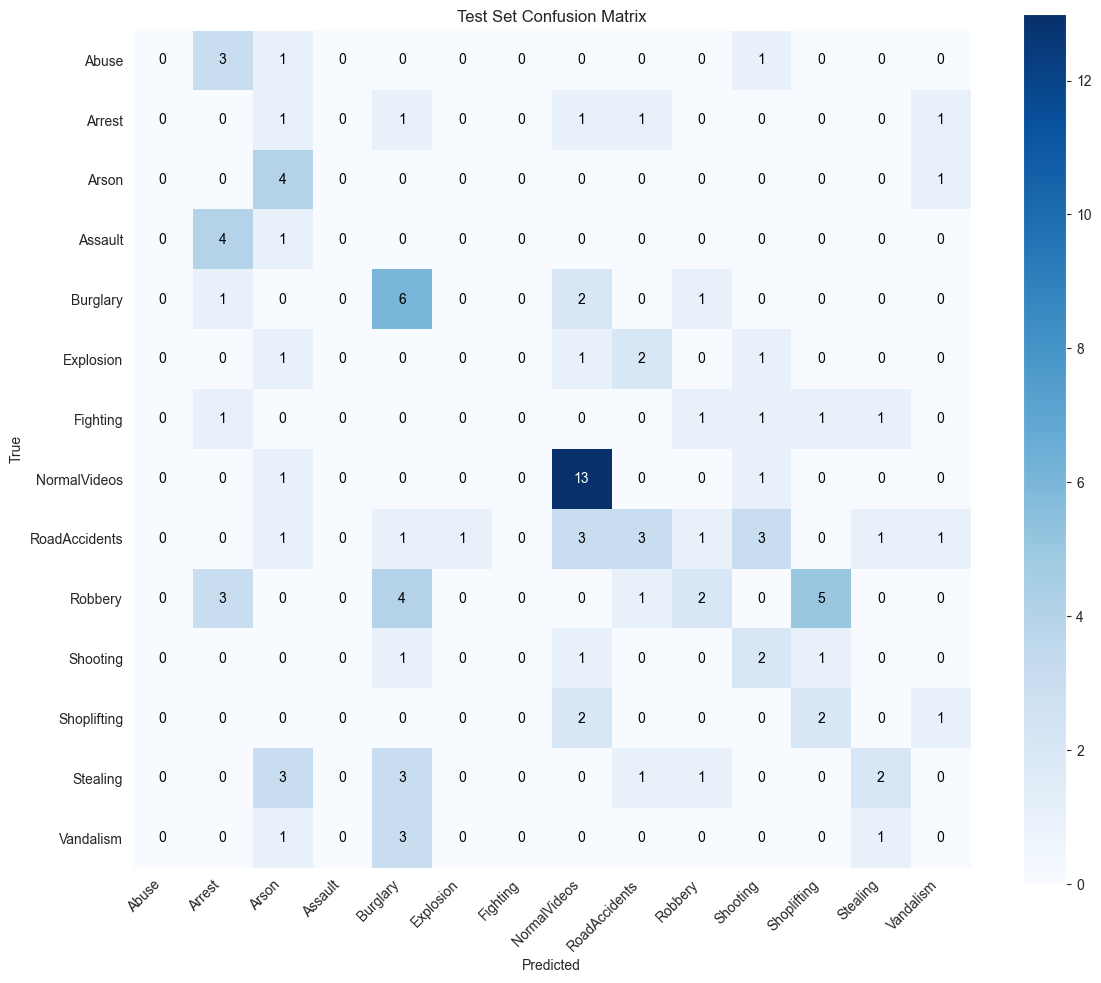


Classification report:
                precision    recall  f1-score   support

        Abuse     0.0000    0.0000    0.0000         5
       Arrest     0.0000    0.0000    0.0000         5
        Arson     0.2857    0.8000    0.4211         5
      Assault     0.0000    0.0000    0.0000         5
     Burglary     0.3158    0.6000    0.4138        10
    Explosion     0.0000    0.0000    0.0000         5
     Fighting     0.0000    0.0000    0.0000         5
 NormalVideos     0.5652    0.8667    0.6842        15
RoadAccidents     0.3750    0.2000    0.2609        15
      Robbery     0.3333    0.1333    0.1905        15
     Shooting     0.2222    0.4000    0.2857         5
  Shoplifting     0.2222    0.4000    0.2857         5
     Stealing     0.4000    0.2000    0.2667        10
    Vandalism     0.0000    0.0000    0.0000         5

     accuracy                         0.3091       110
    macro avg     0.1942    0.2571    0.2006       110
 weighted avg     0.2719    0.3091    

c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [27]:
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap using imshow
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar
plt.colorbar(im, ax=ax)

# Set ticks and labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.set_yticklabels(class_labels)

# Remove grid
ax.grid(False)

# Add text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, int(cm[i, j]),
                      ha="center", va="center",
                      color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(
    all_labels, all_preds, target_names=class_labels, digits=4
)
print("\nClassification report:\n", report)

acc = np.trace(cm) / np.sum(cm)
print(f"\nOverall Test Accuracy: {acc:.4f}")

c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c


Classification report:
                precision    recall  f1-score   support

        Abuse     0.0000    0.0000    0.0000         5
       Arrest     0.0000    0.0000    0.0000         5
        Arson     0.2857    0.8000    0.4211         5
      Assault     0.0000    0.0000    0.0000         5
     Burglary     0.3158    0.6000    0.4138        10
    Explosion     0.0000    0.0000    0.0000         5
     Fighting     0.0000    0.0000    0.0000         5
 NormalVideos     0.5652    0.8667    0.6842        15
RoadAccidents     0.3750    0.2000    0.2609        15
      Robbery     0.3333    0.1333    0.1905        15
     Shooting     0.2222    0.4000    0.2857         5
  Shoplifting     0.2222    0.4000    0.2857         5
     Stealing     0.4000    0.2000    0.2667        10
    Vandalism     0.0000    0.0000    0.0000         5

     accuracy                         0.3091       110
    macro avg     0.1942    0.2571    0.2006       110
 weighted avg     0.2719    0.3091    

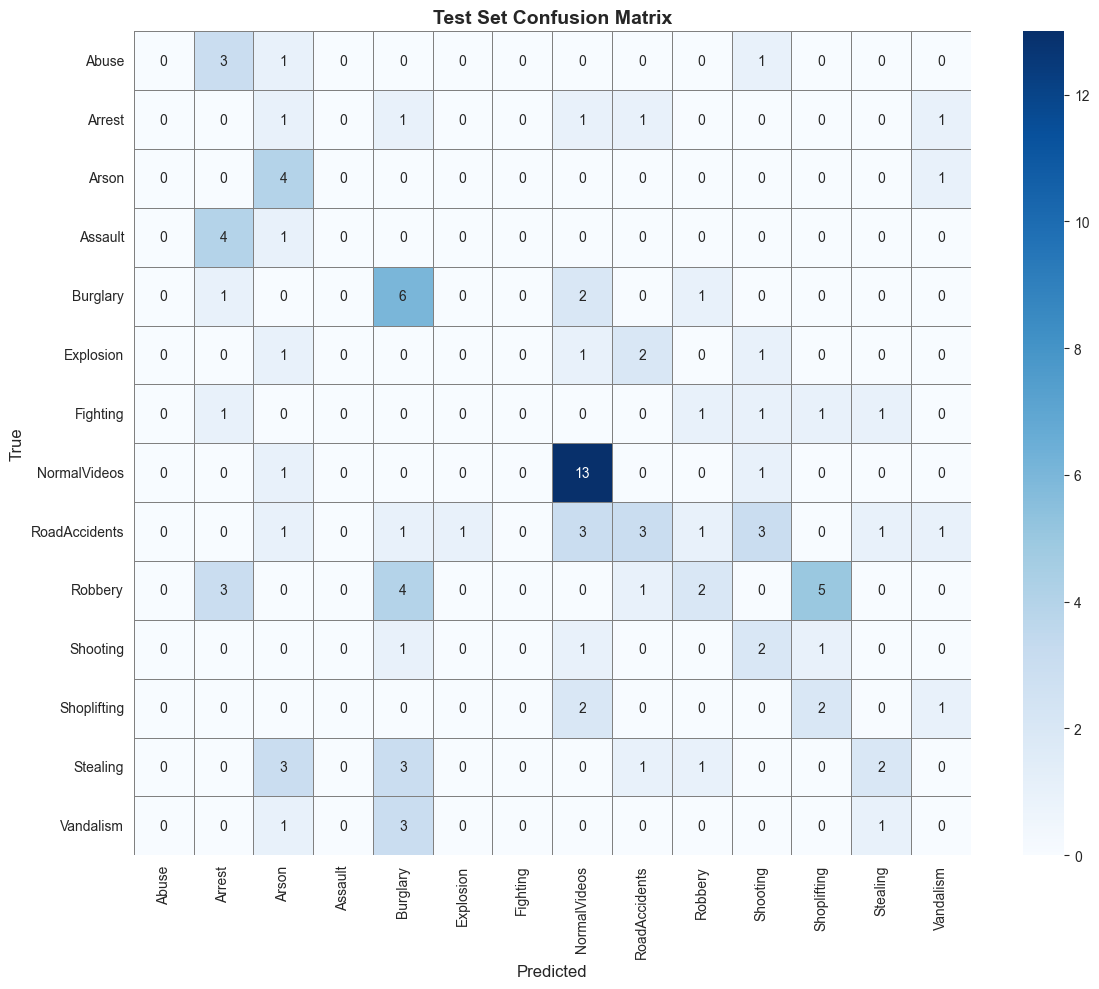

In [28]:
# Set seaborn style
sns.set_style("darkgrid", {"axes.facecolor": ".9", "grid.color": "white"})

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5,
    linecolor='gray'
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Test Set Confusion Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
#cm_path = output_dir / "confusion_matrix.png"
#plt.savefig(cm_path)
#plt.close()
#print(f"Confusion matrix saved to {cm_path}")

# Classification report
report = classification_report(
    all_labels, all_preds, target_names=class_labels, digits=4
)
print("\nClassification report:\n", report)

acc = np.trace(cm) / np.sum(cm)
print(f"\nOverall Test Accuracy: {acc:.4f}")